# Zillow Project
---
## __Robust Analytics™__

__Anthony Straine__<br>
Junior Data Scientist

__Christopher Ortiz__<br>
Junior Data Scientist


## Summary
Working together we discovered for our MVP that the features that appear to drive home value as measure by taxvaluedollarcnt are bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet. We discovered this by going through an iterative, manual process of feature selection using a Pearson's R correlation test to select the top two features of bathroomcnt and calculatedfinishedsquarefeet and using industry knowledge to also include calculatedfinishedsquarefeet and homes having more than 2 bathrooms. After testing a few models, the model that performed the best was our model1 data (bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt) and using a Polynomial-features algorithm. The features in this model explain 47% of the variance.

For our next iteration we will look at additional features while controlling for outliers.


## Content
- [Acquisition](#acquisition)
- [Preparation](#preparation)
- [Exploration](#exploration)
- [Modeling](#modeling)
- [Summary](#summary)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats

from sklearn.feature_selection import RFE
from wrangle import wrangle_data
from prepare import prepare_zillow_mvp
import warnings
warnings.filterwarnings("ignore")

# Acquisition
---

#  Preparation
---

#  Exploration
---
- Discover insights in data with visuals.
- [Hypothesis Testing](#hypothesis-testing)

> Before or after hypothesis tests?
> - Recursive Feature Elimination
> - SelectKBest

In [38]:
df = prepare_zillow_mvp()

In [39]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_data(df, 'taxvaluedollarcnt', modeling=False)

In [40]:
train = pd.concat([X_train, y_train], axis=1)

In [41]:
X_train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,more_than_two_bath
1711167,2.0,3.0,1248.0,0
2312067,2.5,4.0,2269.0,1
1020698,2.0,2.0,980.0,0
2089824,2.0,2.0,1215.0,0
2218083,3.0,3.0,1771.0,1


In [42]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,more_than_two_bath,taxvaluedollarcnt
1711167,2.0,3.0,1248.0,0,396962.0
2312067,2.5,4.0,2269.0,1,630000.0
1020698,2.0,2.0,980.0,0,177856.0
2089824,2.0,2.0,1215.0,0,524893.0
2218083,3.0,3.0,1771.0,1,96286.0


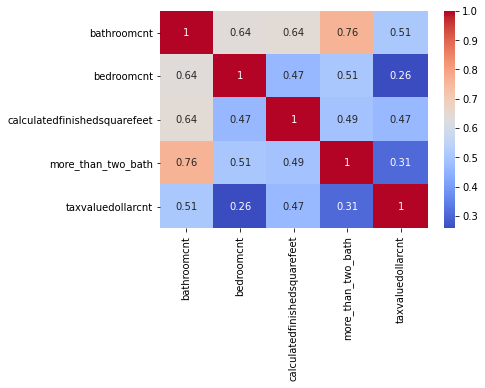

In [43]:
sns.heatmap(train.corr(), annot=True, cmap='coolwarm');

## Hypothesis Testing

### Correlation tests
We'll perform correlation tests using bathroom count and calculated square footage. Let's compare these features with tax value dollar count to see if their is significant.

> Note: Let's test for collinearity between bedrooms and finished squared feet.
<br>

#### Number of Bathrooms

$H0$ - There is no relationship between taxvaluedollarcnt and bathroomcnt.

$H1$ - There is a relationship between taxvaluedollarcnt and bathroomcnt.

In [50]:
a = .05
r, p = stats.pearsonr(train['bathroomcnt'], train['taxvaluedollarcnt'])

print(("Pearsons Correlation Coefficient: {:.2f}" \
      "\nP-Value: {:.2f}\nalpha: {:.2f}\n").format(r, p, alpha))

if p < alpha:
    print("P-Value is less than alpha:")
    print('Reject HO (for H1). There is a linear' \
          ' relationship between tax value of homes and number of bathrooms.')
else:
    print('Fail to reject H0. There is no linear' \
          'relationship between tax value of homes and number of bathrooms.')

Pearsons Correlation Coefficient: 0.51
P-Value: 0.00
alpha: 0.05

P-Value is less than alpha:
Reject HO (for H1). There is a linear relationship between tax value of homes and number of bathrooms.


In [ ]:
# visual 1

#### Finished Square Feet

$H0$ There is no relationship between square feet and home value.

$H1$ There is a relationship between square feet and home value.

In [49]:
confidence_interval = 0.95
alpha = 1 - confidence_interval 

r, p = stats.pearsonr(train['calculatedfinishedsquarefeet'], train['taxvaluedollarcnt'])

print(("Pearsons Correlation Coefficient: {:.2f}" \
      "\nP-Value: {:.2f}\nalpha: {:.2f}\n").format(r, p, alpha))

if p < alpha:
    print("P-Value is less than alpha:")
    print('Reject HO (for H1). There is a linear' \
          ' relationship between square feet and home value.')
else:
    print('Fail to reject H0. There is no linear' \
          'relationship between square feet and home value.')

Pearsons Correlation Coefficient: 0.47
P-Value: 0.00
alpha: 0.05

P-Value is less than alpha:
Reject HO (for H1). There is a linear relationship between square feet and home value.


In [51]:
# visual 2

### T-test
One Tailed t-test

#### Number of Bathrooms: More than 2 bathrooms

In [ ]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_data(df, 'taxvaluedollarcnt')
train = pd.concat([X_train, y_train], axis=1)

train.head()

$H0$ The average price of homes with more than two bathrooms is equal to the average price of homes with two or less bathrooms.

$H1$ Homes with more than two bathrooms have higher than average tax dollar count.

In [ ]:
df_two_or_less_restrooms = train[train.bathroomcnt <= 2]
df_greater_than_two_restrooms = train[train.bathroomcnt > 2]

In [52]:
# clean this section
a = df_two_or_less_restrooms.taxvaluedollarcnt.mean()

b = df_greater_than_two_restrooms.taxvaluedollarcnt.mean()

t, p = stats.ttest_ind(df_greater_than_two_restrooms.taxvaluedollarcnt,
                df_two_or_less_restrooms.taxvaluedollarcnt)

p = p/2

# Evaluate the significance of the p-value against alpha.
print("T-Statistic: {:.2f}\nP-Value: {:.2f}\nalpha: {:.2f}\n".format(t, p, alpha))

# Determine the appropriate Hypothesis.
if p < alpha:
    print("P-Value is less than alpha:")
    print('Reject HO (for H1).' \
          ' Homes with more than two bathrooms have higher than average tax dollar count.')
else:
    print('Fail to reject H0. The average price of homes with more than two bathrooms is equal' \
          ' to the average price of homes with two or less bathrooms.')

T-Statistic: 378.93
P-Value: 0.00
alpha: 0.05

P-Value is less than alpha:
Reject HO (for H1). Homes with more than two bathrooms have higher than average tax dollar count.


# Modeling
---

In [12]:
# create the Zillow DataFrame
df = prepare_zillow_mvp()

# Create model data frames for each feature set we will use for various models
model_1_data = df.drop(columns='more_than_two_bath')
model_2_data = df[['more_than_two_bath','taxvaluedollarcnt']]
model_3_data = df[['calculatedfinishedsquarefeet', 'more_than_two_bath', 'taxvaluedollarcnt']]

In [13]:
# Split model 1 into X_train, y_train, X_validate, y_validate, X_test, y_test

X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_data(model_1_data, 'taxvaluedollarcnt', modeling=True)

df_model_evals = pd.DataFrame()

df_model_evals['y'] = y_train
df_model_evals['baseline_yhat'] = y_train.mean()

rmse_poly = sqrt(mean_squared_error(df_model_evals.y, df_model_evals.baseline_yhat))
rsquared_poly = explained_variance_score(y_train, df_model_evals.baseline_yhat)

print("Baseline Model")
print('-' * 24)
print(f"Basline Model RMSE: {rmse_poly:.2f}")
print(f"Basline R^2: {rsquared_poly:.2%}")


Baseline Model
------------------------
Basline Model RMSE: 672494.82
Basline R^2: 0.00%


In [14]:
# Create a polynomial linear regression
poly = PolynomialFeatures(3)

X_train_poly = poly.fit_transform(X_train)
X_validate_poly = poly.transform(X_validate)
X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()
lm_poly.fit(X_train_poly, y_train)

yhat_poly_train = lm_poly.predict(X_train_poly)
poly_train_residuals = yhat_poly_train - y_train

df_model_evals['poly_1_yhat'] = lm_poly.predict(X_train_poly)

rmse_poly = sqrt(mean_squared_error(y_train, yhat_poly_train))
rsquared_poly = explained_variance_score(y_train, yhat_poly_train)

print("Train Set\nPolynomial : degree=3")
print('-' * 24)
print(f"Polynomial Model RMSE: {rmse_poly:.2f}")
print(f"Polynomial R^2: {rsquared_poly:.2%}")

Train Set
Polynomial : degree=3
------------------------
Polynomial Model RMSE: 490288.02
Polynomial R^2: 46.85%


In [15]:
# Look at the evals dataframe for peace of mind
df_model_evals.head()

,y,baseline_yhat,poly_1_yhat
1711167,396962.0,460756.703083,263984.028220
2312067,630000.0,460756.703083,467517.903765
1020698,177856.0,460756.703083,251231.178129
2089824,524893.0,460756.703083,321888.391171
2218083,96286.0,460756.703083,441210.512722


# Summary
---
Working together we discovered for our MVP that the features that appear to drive home value as measure by taxvaluedollarcnt are bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet. We discovered this by going through an iterative, manual process of feature selection using a Pearson's R correlation test to select the top two features of bathroomcnt and calculatedfinishedsquarefeet and using industry knowledge to also include calculatedfinishedsquarefeet and homes having more than 2 bathrooms. After testing a few models, the model that performed the best was our model1 data (bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt) and using a Polynomial-features algorithm. The features in this model explain 47% of the variance.

For our next iteration we will look at additional features while controlling for outliers.